In [1]:
import json

from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import DoubleType
import pandas as  pd
import requests
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# I ) - importation de données :
>> ### + La première étape consiste à importer des données à partir de l'API et à les structurer correctement.

In [ ]:


# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2023-01-01&end_date=2023-12-31&hourly=temperature_2m"""
response = requests.get(url)
print(response)
data_json = response.json()
print(json.dumps(data_json, indent=4))
# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas    

<Response [200]>
{
    "latitude": 52.54833,
    "longitude": 13.407822,
    "generationtime_ms": 0.07605552673339844,
    "utc_offset_seconds": 0,
    "timezone": "GMT",
    "timezone_abbreviation": "GMT",
    "elevation": 38.0,
    "hourly_units": {
        "time": "iso8601",
        "temperature_2m": "\u00b0C"
    },
    "hourly": {
        "time": [
            "2023-01-01T00:00",
            "2023-01-01T01:00",
            "2023-01-01T02:00",
            "2023-01-01T03:00",
            "2023-01-01T04:00",
            "2023-01-01T05:00",
            "2023-01-01T06:00",
            "2023-01-01T07:00",
            "2023-01-01T08:00",
            "2023-01-01T09:00",
            "2023-01-01T10:00",
            "2023-01-01T11:00",
            "2023-01-01T12:00",
            "2023-01-01T13:00",
            "2023-01-01T14:00",
            "2023-01-01T15:00",
            "2023-01-01T16:00",
            "2023-01-01T17:00",
            "2023-01-01T18:00",
            "2023-01-01T19:00",
    

,time,temperature_2m
0,2023-01-01 00:00:00,15.3
1,2023-01-01 01:00:00,15.7
2,2023-01-01 02:00:00,15.8
3,2023-01-01 03:00:00,15.9
4,2023-01-01 04:00:00,15.8
...,...,...
8755,2023-12-31 19:00:00,6.3
8756,2023-12-31 20:00:00,6.7
8757,2023-12-31 21:00:00,6.1
8758,2023-12-31 22:00:00,5.2


In [2]:

spark = SparkSession.builder \
    .appName("ReadSnappyParquet") \
    .getOrCreate()

In [ ]:
spark.stopSession()

NameError: name 'spark' is not defined

In [9]:
spark = SparkSession.builder.appName("ReadSnappyParquet").getOrCreate()

# Dừng session
spark.stop()

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.spark.SparkException: Only one SparkContext should be running in this JVM (see SPARK-2243).The currently running SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:76)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:53)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:1589)
	at org.apache.spark.SparkContext$.$anonfun$assertNoOtherContextIsRunning$2(SparkContext.scala:2840)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.SparkContext$.assertNoOtherContextIsRunning(SparkContext.scala:2837)
	at org.apache.spark.SparkContext$.markPartiallyConstructed(SparkContext.scala:2927)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:99)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:76)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:53)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)


In [3]:

# Path to the .snappy.parquet file or directory
parquet_path = "D:/Time-Series-Forecasting-Spark-Kafka-for-Weather-Data-main/delta_lake/delta_lake_table_3/"

# Read the .snappy.parquet files
df = spark.read.parquet(parquet_path)

# Display the content
df.show()

# Print schema



+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible|
|2024-10-18 10:00:00|Hanoi|Vietnam| 21.0333|   105.85|  30.7|     5.1|    62.0|     0.29|   Light rain shower|
|

In [4]:
df_pandas = df.toPandas() 

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


In [5]:
df = df.select("datetime", "temp_c")
df.show()

+-------------------+------+
|           datetime|temp_c|
+-------------------+------+
|2024-10-18 05:00:00|  25.0|
|2024-10-18 06:00:00|  24.9|
|2024-10-18 07:00:00|  25.9|
|2024-10-18 08:00:00|  27.5|
|2024-10-18 09:00:00|  29.2|
|2024-10-18 10:00:00|  30.7|
|2024-10-18 11:00:00|  31.7|
|2024-10-18 12:00:00|  32.4|
|2024-10-18 13:00:00|  31.8|
|2024-10-18 14:00:00|  31.5|
|2024-10-18 15:00:00|  31.4|
|2024-10-18 16:00:00|  30.7|
|2024-10-18 17:00:00|  29.9|
|2024-10-18 18:00:00|  28.6|
|2024-10-18 19:00:00|  27.7|
|2024-10-18 20:00:00|  27.1|
|2024-10-18 21:00:00|  26.6|
|2024-10-18 22:00:00|  26.3|
|2024-10-18 23:00:00|  26.0|
|2024-10-19 00:00:00|  25.4|
+-------------------+------+
only showing top 20 rows



>> ### - Ensuite, nous devons convertir les données extraites en un DataFrame Spark, afin de pouvoir les traiter librement et entraîner les modèles d'apprentissage automatique.

In [6]:
# Create a Spark session
spark = SparkSession.builder.appName("example").config("spark.executor.memory", "4g").config("spark.driver.memory", "7g").getOrCreate()
# df = spark.createDataFrame(df)

# II) - exploration de données

> ## 1) - Exploreration des valeurs manquantes

In [7]:
# Check for null values in each column
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"Null values in column '{column}': {null_count}")

Null values in column 'datetime': 0
Null values in column 'temp_c': 0


> ## 2) - visualisation de l'évolution des températures sur les 4 dernières années

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


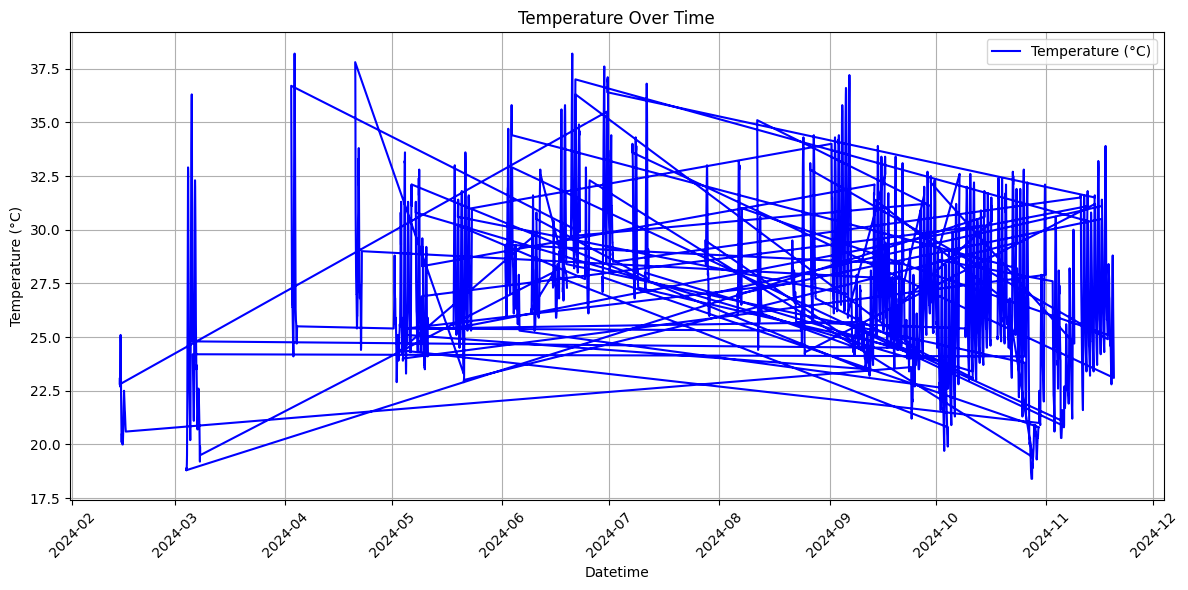

In [10]:
sampled_df = df.select("datetime", "temp_c").limit(3000)

# Chuyển đổi Spark DataFrame sang Pandas DataFrame
pandas_df = sampled_df.toPandas()

# Chuyển đổi cột 'datetime' sang định dạng datetime của Pandas
pandas_df['datetime'] = pd.to_datetime(pandas_df['datetime'])

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['datetime'], pandas_df['temp_c'], color='blue', label='Temperature (°C)')

# Tùy chỉnh biểu đồ
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Xoay trục x để dễ đọc hơn
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarn

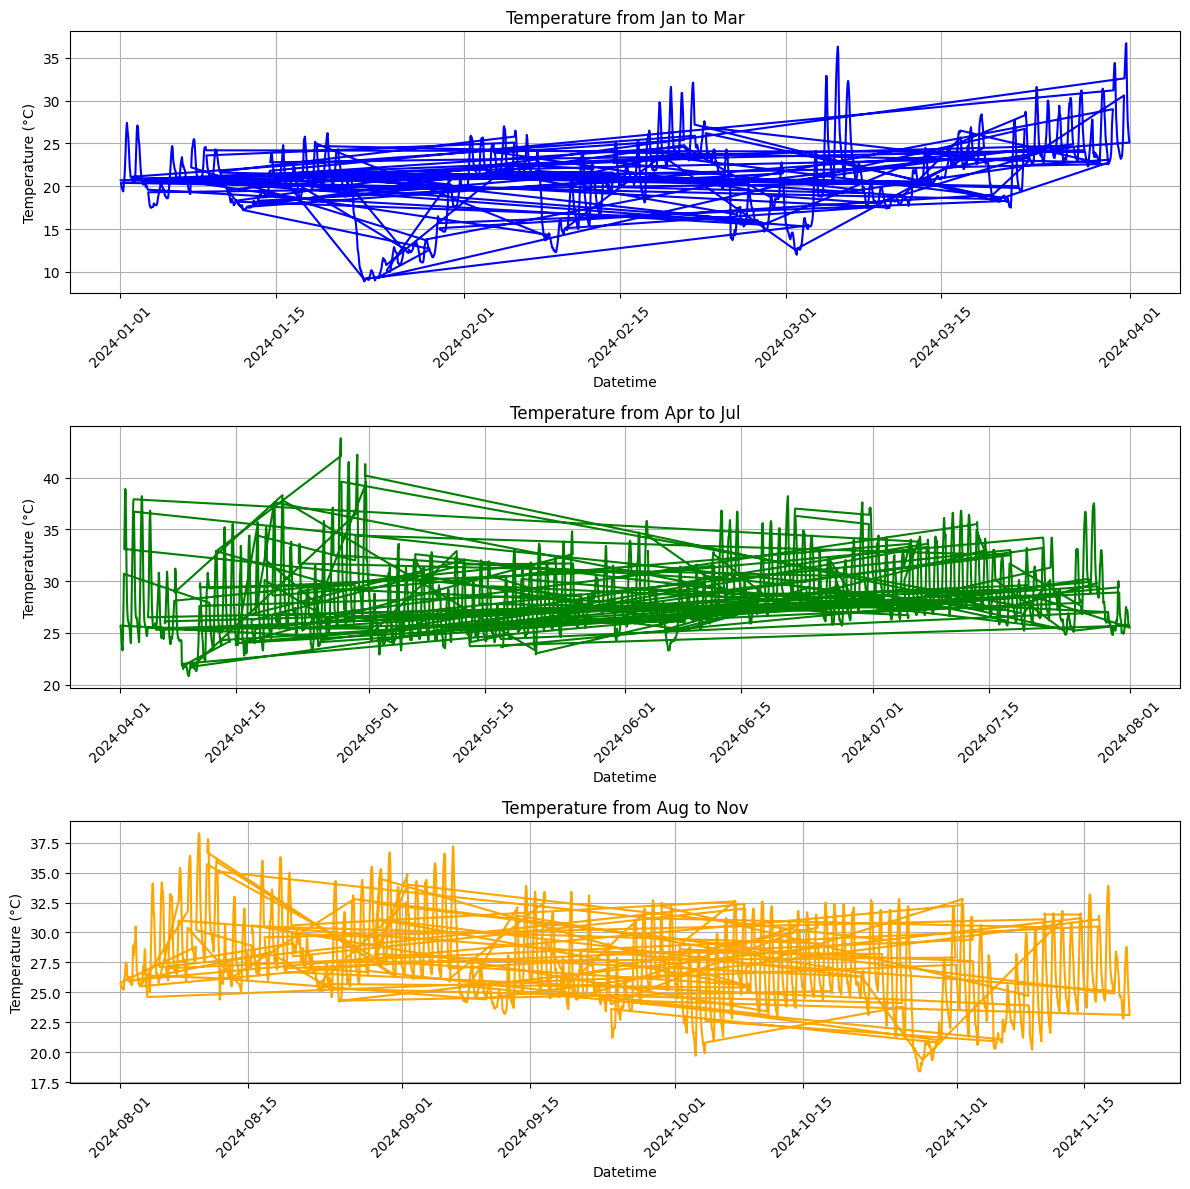

In [9]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import month

# Chia dữ liệu thành 3 khoảng thời gian
data_jan_mar = df.filter((month("datetime") >= 1) & (month("datetime") <= 3))
data_apr_jul = df.filter((month("datetime") >= 4) & (month("datetime") <= 7))
data_aug_nov = df.filter((month("datetime") >= 8) & (month("datetime") <= 11))

# Chuyển từng tập dữ liệu sang Pandas
data_jan_mar_pd = data_jan_mar.toPandas()
data_apr_jul_pd = data_apr_jul.toPandas()
data_aug_nov_pd = data_aug_nov.toPandas()

# Vẽ các biểu đồ
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

# Biểu đồ cho tháng 1-3
axes[0].plot(data_jan_mar_pd['datetime'], data_jan_mar_pd['temp_c'], color="blue")
axes[0].set_title("Temperature from Jan to Mar")
axes[0].set_xlabel("Datetime")
axes[0].set_ylabel("Temperature (°C)")

# Biểu đồ cho tháng 4-7
axes[1].plot(data_apr_jul_pd['datetime'], data_apr_jul_pd['temp_c'], color="green")
axes[1].set_title("Temperature from Apr to Jul")
axes[1].set_xlabel("Datetime")
axes[1].set_ylabel("Temperature (°C)")

# Biểu đồ cho tháng 8-11
axes[2].plot(data_aug_nov_pd['datetime'], data_aug_nov_pd['temp_c'], color="orange")
axes[2].set_title("Temperature from Aug to Nov")
axes[2].set_xlabel("Datetime")
axes[2].set_ylabel("Temperature (°C)")

# Tùy chỉnh đồ thị
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()


In [11]:
limited_data

NameError: name 'limited_data' is not defined

> ## 2) - visualisation de l'évolution des températures pour l'année en cours

In [12]:
df = df.orderBy('datetime')
plt.figure(figsize=(12, 4))
plt.plot(df.select('datetime').rdd.flatMap(lambda x: x).collect()[-9000:], df.select('temp_c').rdd.flatMap(lambda x: x).collect()[-9000:], color='red', label='Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 20.0 failed 1 times, most recent failure: Lost task 0.0 in stage 20.0 (TID 141) (LAPTOP-DN3PCHGN executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.5.3-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 10) than that in driver 3.11, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1589)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:76)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark-3.5.3-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 10) than that in driver 3.11, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


<Figure size 1200x400 with 0 Axes>

# III) - feature Engineering : indexation chronologique
> ## 1) - maintenant, nous allons supprimer toutes les colonnes sauf « temps » et « température ».
>> - variable explicable : température.
>> - variable explicative : temps

In [13]:
# Select only the "time" and "assembled_features" columns
df = df.select("datetime", "temp_c")
df.show()

+-------------------+------+
|           datetime|temp_c|
+-------------------+------+
|2024-01-01 00:00:00|  20.7|
|2024-01-01 01:00:00|  20.4|
|2024-01-01 02:00:00|  20.0|
|2024-01-01 03:00:00|  19.8|
|2024-01-01 04:00:00|  19.6|
|2024-01-01 05:00:00|  19.6|
|2024-01-01 06:00:00|  19.4|
|2024-01-01 07:00:00|  20.0|
|2024-01-01 08:00:00|  20.5|
|2024-01-01 09:00:00|  21.3|
|2024-01-01 10:00:00|  22.5|
|2024-01-01 11:00:00|  23.9|
|2024-01-01 12:00:00|  25.7|
|2024-01-01 13:00:00|  26.9|
|2024-01-01 14:00:00|  27.4|
|2024-01-01 15:00:00|  26.7|
|2024-01-01 16:00:00|  26.2|
|2024-01-01 17:00:00|  25.6|
|2024-01-01 18:00:00|  24.6|
|2024-01-01 19:00:00|  23.4|
+-------------------+------+
only showing top 20 rows



> ## 2) - Si nous avons besoin de créer un modèle capable de prédire la température du futur, nous devons entraîner ce modèle sur des données ne contenant que des indices temporels. Ainsi, nous pourrons le former à cartographier la relation entre le temps et la variable cible. Pour ce faire, nous allons utiliser le script suivant.

In [14]:
data = df
df = (df
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
df.show()

+-------------------+------+----+----+-----+-------+-----------+------------+-----------+
|           datetime|temp_c|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+------+----+----+-----+-------+-----------+------------+-----------+
|2024-01-01 00:00:00|  20.7|   0|   1|    1|      1|          2|           1|          1|
|2024-01-01 01:00:00|  20.4|   1|   1|    1|      1|          2|           1|          1|
|2024-01-01 02:00:00|  20.0|   2|   1|    1|      1|          2|           1|          1|
|2024-01-01 03:00:00|  19.8|   3|   1|    1|      1|          2|           1|          1|
|2024-01-01 04:00:00|  19.6|   4|   1|    1|      1|          2|           1|          1|
|2024-01-01 05:00:00|  19.6|   5|   1|    1|      1|          2|           1|          1|
|2024-01-01 06:00:00|  19.4|   6|   1|    1|      1|          2|           1|          1|
|2024-01-01 07:00:00|  20.0|   7|   1|    1|      1|          2|           1|          1|
|2024-01-0

> ## 3) -  la normalisation des  columns  :
>> #### La normalisation des données est cruciale pour garantir que toutes les caractéristiques contribuent équitablement aux modèles d'apprentissage automatique. Cela permet d'éviter que des variables avec des échelles différentes ne dominent l'apprentissage du modèle.







In [15]:
data = df 

In [16]:
# Select columns to normalize
columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)

In [17]:
df.show()

+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+
|           datetime|temp_c|                hour|week|month|quarter|        day_of_week|day_of_month|day_of_year|
+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+
|2024-01-01 00:00:00|  20.7|                 0.0| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 01:00:00|  20.4|0.043478260869565216| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 02:00:00|  20.0| 0.08695652173913043| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 03:00:00|  19.8| 0.13043478260869565| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 04:00:00|  19.6| 0.17391304347826086| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 05:00:00|  19.6| 0.21739130434782608| 0.0|  0.0|    0.0|0.16666666666666666|

In [18]:
data = df

# IV) - Entraînement et évaluation des modèles.
> ### Dans cette section, nous allons essayer d'Entraîner plusieurs modèles sur nos données et choisir le modèle le plus performant

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
def display_model_performance(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # Convert the PySpark DataFrame to a Pandas DataFrame
    result_df = predictions.select("label", "prediction").toPandas()

    # Plot the graph
    plt.plot(result_df['label'], result_df['prediction'], 'bo')
    plt.xlabel('Temperature')
    plt.ylabel('Prediction')
    plt.suptitle("Model Performance RMSE: %f" % rmse)
    plt.show()
    

def evaluate_model(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)
    forecast_bias = predictions.agg(F.avg(predictions['label'] - predictions['prediction'])).collect()[0][0]

    # Calculate R-squared (R2)
    evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
    r2 = evaluator.evaluate(predictions)

    # Calculate Mean Absolute Scaled Error (MASE)
    mean_absolute_error = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})
    mase = mean_absolute_error / predictions.agg(F.mean('label')).collect()[0][0]

    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_numerator = F.sum(F.abs(predictions['label'] - predictions['prediction']))
    smape_denominator = F.sum(F.abs(predictions['label']) + F.abs(predictions['prediction']))
    smape = F.when(smape_denominator == 0, 0).otherwise(200 * smape_numerator / smape_denominator)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = F.avg(F.abs(predictions['label'] - predictions['prediction']) / F.abs(predictions['label']))

    # Calculate Root Mean Squared Error (RMSE)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

    # Calculate Mean Squared Error (MSE)
    mse = evaluator.evaluate(predictions, {evaluator.metricName: 'mse'})

    # Calculate Mean Absolute Error (MAE)
    mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

    # Print the metrics
    print(f"Forecast Bias: {forecast_bias}")
    print(f"R-squared (R2): {r2}")
    print(f"Mean Absolute Scaled Error (MASE): {mase}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return [ forecast_bias , r2 , mase , rmse , mse , mae ]
#  [ 'Forecast Bias' , 'R-squared (R2)' , 'Mean Absolute Scaled Error (MASE)' , 'Root Mean Squared Error (RMSE)','Mean Squared Error (MSE)' , 'Mean Absolute Error (MAE)']


In [20]:
data = df 
df = df.drop('time')

In [21]:
from pyspark.ml.feature import VectorAssembler
feature_list = []
df = df.withColumnRenamed("temperature_2m", "label")
for col in df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [22]:
# Sort the data based on 'time'
df = df.orderBy('time')

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `time` cannot be resolved. Did you mean one of the following? [`week`, `datetime`, `hour`, `temp_c`, `month`].;
'Sort ['time ASC NULLS FIRST], true
+- Project [datetime#0, temp_c#5, hour#241, week#303, month#365, quarter#427, day_of_week#489, day_of_month#551, day_of_year_normalized#593 AS day_of_year#613]
   +- Project [datetime#0, temp_c#5, hour#241, week#303, month#365, quarter#427, day_of_week#489, day_of_month#551, day_of_year_normalized#593]
      +- Project [datetime#0, temp_c#5, day_of_year#142, hour#241, week#303, month#365, quarter#427, day_of_week#489, day_of_month#551, (cast((day_of_year#142 - 1) as double) / cast(323 as double)) AS day_of_year_normalized#593]
         +- Project [datetime#0, temp_c#5, day_of_year#142, hour#241, week#303, month#365, quarter#427, day_of_week#489, day_of_month_normalized#531 AS day_of_month#551]
            +- Project [datetime#0, temp_c#5, day_of_year#142, hour#241, week#303, month#365, quarter#427, day_of_week#489, day_of_month_normalized#531]
               +- Project [datetime#0, temp_c#5, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, quarter#427, day_of_week#489, (cast((day_of_month#133 - 1) as double) / cast(30 as double)) AS day_of_month_normalized#531]
                  +- Project [datetime#0, temp_c#5, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, quarter#427, day_of_week_normalized#469 AS day_of_week#489]
                     +- Project [datetime#0, temp_c#5, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, quarter#427, day_of_week_normalized#469]
                        +- Project [datetime#0, temp_c#5, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, quarter#427, (cast((day_of_week#125 - 1) as double) / cast(6 as double)) AS day_of_week_normalized#469]
                           +- Project [datetime#0, temp_c#5, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, quarter_normalized#407 AS quarter#427]
                              +- Project [datetime#0, temp_c#5, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, quarter_normalized#407]
                                 +- Project [datetime#0, temp_c#5, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, month#365, (cast((quarter#118 - 1) as double) / cast(3 as double)) AS quarter_normalized#407]
                                    +- Project [datetime#0, temp_c#5, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, month_normalized#345 AS month#365]
                                       +- Project [datetime#0, temp_c#5, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, month_normalized#345]
                                          +- Project [datetime#0, temp_c#5, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week#303, (cast((month#112 - 1) as double) / cast(10 as double)) AS month_normalized#345]
                                             +- Project [datetime#0, temp_c#5, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week_normalized#283 AS week#303]
                                                +- Project [datetime#0, temp_c#5, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, week_normalized#283]
                                                   +- Project [datetime#0, temp_c#5, week#107, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour#241, (cast((week#107 - 1) as double) / cast(46 as double)) AS week_normalized#283]
                                                      +- Project [datetime#0, temp_c#5, week#107, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour_normalized#221 AS hour#241]
                                                         +- Project [datetime#0, temp_c#5, week#107, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, hour_normalized#221]
                                                            +- Project [datetime#0, temp_c#5, hour#103, week#107, month#112, quarter#118, day_of_week#125, day_of_month#133, day_of_year#142, (cast((hour#103 - 0) as double) / cast(23 as double)) AS hour_normalized#221]
                                                               +- Project [datetime#0, temp_c#5, hour#103, week#107, month#112, quarter#118, day_of_week#125, day_of_month#133, dayofyear(cast(datetime#0 as date)) AS day_of_year#142]
                                                                  +- Project [datetime#0, temp_c#5, hour#103, week#107, month#112, quarter#118, day_of_week#125, dayofmonth(cast(datetime#0 as date)) AS day_of_month#133]
                                                                     +- Project [datetime#0, temp_c#5, hour#103, week#107, month#112, quarter#118, dayofweek(cast(datetime#0 as date)) AS day_of_week#125]
                                                                        +- Project [datetime#0, temp_c#5, hour#103, week#107, month#112, quarter(cast(datetime#0 as date)) AS quarter#118]
                                                                           +- Project [datetime#0, temp_c#5, hour#103, week#107, month(cast(datetime#0 as date)) AS month#112]
                                                                              +- Project [datetime#0, temp_c#5, hour#103, weekofyear(cast(datetime#0 as date)) AS week#107]
                                                                                 +- Project [datetime#0, temp_c#5, hour(datetime#0, Some(Asia/Bangkok)) AS hour#103]
                                                                                    +- Project [datetime#0, temp_c#5]
                                                                                       +- Sort [datetime#0 ASC NULLS FIRST], true
                                                                                          +- Project [datetime#0, temp_c#5]
                                                                                             +- Relation [datetime#0,name#1,country#2,latitude#3,longitude#4,temp_c#5,wind_mph#6,humidity#7,precip_mm#8,condition#9] parquet


> ## 1) - Construction et entrainement du modèle Random Forest Regressor.

>>> ### a) Construction du model 

In [23]:
feature_cols = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']  # Các feature không có 'datetime'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [24]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf])

In [25]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [26]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [27]:
from pyspark.sql.functions import col, to_timestamp

df = data.withColumnRenamed('temp_c', 'label')
df = df.withColumn("datetime", to_timestamp("datetime"))
trainingData = df.filter(col('datetime') < '2024-10-01 12:00:00').drop('datetime')
testData = df.filter(col('datetime') >= '2024-10-01 12:00:00').drop('datetime')
trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

testData.show(10)

+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
|label|              hour|              week|month|quarter|       day_of_week|day_of_month|      day_of_year|
+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
| 29.0|0.5217391304347826|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 28.5|0.5652173913043478|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 28.0|0.6086956521739131|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 27.1|0.6521739130434783|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 25.9|0.6956521739130435|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 25.1|0.7391304347826086|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 24.3| 0.

In [28]:
trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

In [29]:
trainingData

DataFrame[label: double, hour: double, week: double, month: double, quarter: double, day_of_week: double, day_of_month: double, day_of_year: double]

>>> ### b) Entrainement du model 

In [30]:
cvModel = crossval.fit(trainingData)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22984\3962662358.py", line 1, in <module>
    cvModel = crossval.fit(trainingData)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\ml\base.py", line 205, in fit
    return self._fit(dataset)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\ml\tuning.py", line 847, in _fit
    for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\pool.py", line 873, in next
    raise value
  File "c:\Users\ADMIN\AppData\Local\Programs\Pyth

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

>>> ### c) Prediction du model 

In [ ]:
predictions = cvModel.transform(testData)
predictions

NameError: name 'cvModel' is not defined

In [ ]:
testData.show(5)  # Check the first few rows of testData


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

>>> ### d) évaluation des performances du modèle

In [ ]:
models_performance = []
models_performance.append(['RandomForestRegressor']+evaluate_model(cvModel, testData))

Forecast Bias: -3.912016360945045
R-squared (R2): 0.22866672742230054
Mean Absolute Scaled Error (MASE): 0.5546955211218826
Root Mean Squared Error (RMSE): 4.964082691394334
Mean Squared Error (MSE): 24.642116967000817
Mean Absolute Error (MAE): 3.9449308926344364


>>> ### d) Analyse de l'importance des variables explicatives pour la prédiction

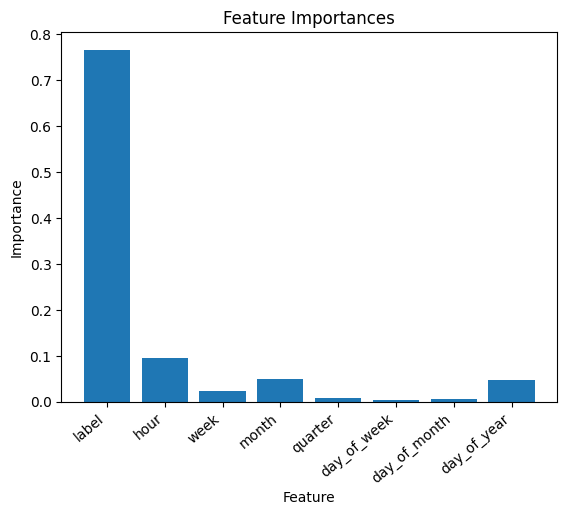

In [ ]:
display_feature_importances(cvModel)

>>> ### e) - analyse la cohérence entre la température prévue et la température réelle

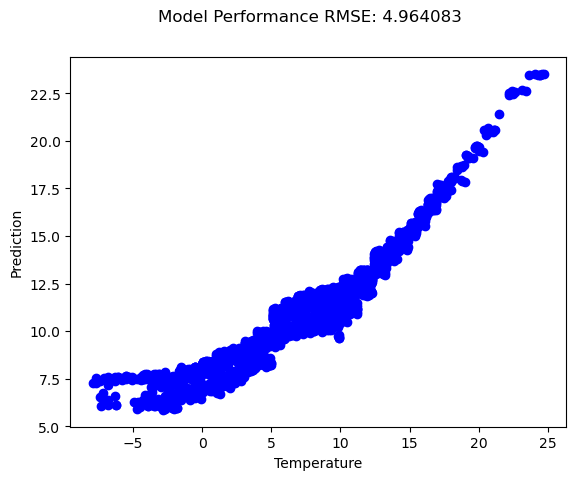

In [ ]:
display_model_performance(cvModel, testData)

        Feature  Importance
0         label    0.579855
2          week    0.155889
7   day_of_year    0.115613
3         month    0.061769
4       quarter    0.050890
1          hour    0.026368
6  day_of_month    0.007178
5   day_of_week    0.002437


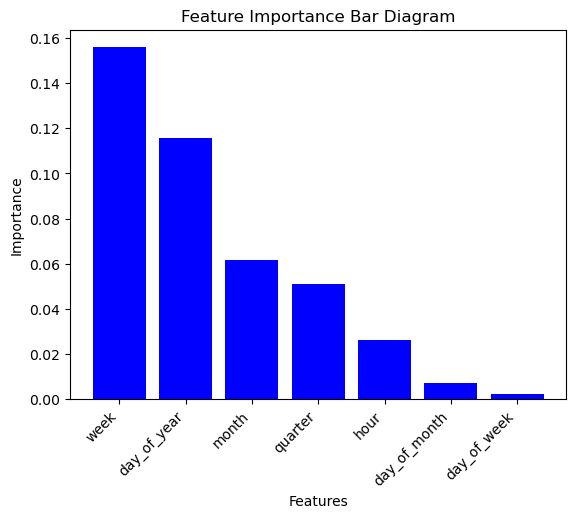

In [ ]:
# Extract feature importances from the trained RandomForestRegressor model
feature_importances = cvModel.bestModel.stages[-1].featureImportances
feature_importance_df = pd.DataFrame({
    'Feature': assembler.getInputCols(),
    'Importance': feature_importances.toArray()
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

importance = list(feature_importance_df.Importance )[1:]
Feature = list(feature_importance_df.Feature )[1:]

plt.bar(Feature, importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Diagram')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Save the model to a folder
cvModel.save("models/random_forest_model")

24/11/16 12:26:31 WARN TaskSetManager: Stage 3402 contains a task of very large size (1229 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2024-01-01&end_date=2024-03-15&hourly=temperature_2m"""
response = requests.get(url)
print(response)
data_json = response.json()
print(json.dumps(data_json, indent=4))
# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas    

<Response [200]>
{
    "latitude": 52.54833,
    "longitude": 13.407822,
    "generationtime_ms": 0.048041343688964844,
    "utc_offset_seconds": 0,
    "timezone": "GMT",
    "timezone_abbreviation": "GMT",
    "elevation": 38.0,
    "hourly_units": {
        "time": "iso8601",
        "temperature_2m": "\u00b0C"
    },
    "hourly": {
        "time": [
            "2024-01-01T00:00",
            "2024-01-01T01:00",
            "2024-01-01T02:00",
            "2024-01-01T03:00",
            "2024-01-01T04:00",
            "2024-01-01T05:00",
            "2024-01-01T06:00",
            "2024-01-01T07:00",
            "2024-01-01T08:00",
            "2024-01-01T09:00",
            "2024-01-01T10:00",
            "2024-01-01T11:00",
            "2024-01-01T12:00",
            "2024-01-01T13:00",
            "2024-01-01T14:00",
            "2024-01-01T15:00",
            "2024-01-01T16:00",
            "2024-01-01T17:00",
            "2024-01-01T18:00",
            "2024-01-01T19:00",
   

,time,temperature_2m
0,2024-01-01 00:00:00,5.0
1,2024-01-01 01:00:00,5.4
2,2024-01-01 02:00:00,5.1
3,2024-01-01 03:00:00,4.7
4,2024-01-01 04:00:00,4.4
...,...,...
1795,2024-03-15 19:00:00,11.4
1796,2024-03-15 20:00:00,11.2
1797,2024-03-15 21:00:00,10.4
1798,2024-03-15 22:00:00,10.5


In [ ]:
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline

# Try loading as a PipelineModel first
try:
    loaded_model = PipelineModel.load("models/random_forest_model/bestModel")
except Exception as e:
    print("Failed to load as PipelineModel, trying Pipeline...")
    try:
        loaded_model = Pipeline.load("models/random_forest_model/bestModel")
    except Exception as e2:
        print("Both loading methods failed.")
        print("PipelineModel error:", e)
        print("Pipeline error:", e2)
        raise e2

# Once loaded, convert your data if needed
if isinstance(df_pandas, pd.DataFrame):
    spark_df = spark.createDataFrame(df_pandas)
else:
    spark_df = df_pandas
feature_list = []
spark_df = spark_df.withColumnRenamed("temperature_2m", "label")
for col in spark_df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
df = spark_df
df = (df
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)
df.show()
from pyspark.sql.functions import col, to_timestamp

columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)
df = data.withColumnRenamed('temperature_2m', 'label')
df = df.withColumn("time", to_timestamp("time"))


+-------------------+-----+----+----+-----+-------+-----------+------------+-----------+
|               time|label|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----+----+----+-----+-------+-----------+------------+-----------+
|2024-01-01 00:00:00|  5.0|   0|   1|    1|      1|          2|           1|          1|
|2024-01-01 01:00:00|  5.4|   1|   1|    1|      1|          2|           1|          1|
|2024-01-01 02:00:00|  5.1|   2|   1|    1|      1|          2|           1|          1|
|2024-01-01 03:00:00|  4.7|   3|   1|    1|      1|          2|           1|          1|
|2024-01-01 04:00:00|  4.4|   4|   1|    1|      1|          2|           1|          1|
|2024-01-01 05:00:00|  3.9|   5|   1|    1|      1|          2|           1|          1|
|2024-01-01 06:00:00|  3.8|   6|   1|    1|      1|          2|           1|          1|
|2024-01-01 07:00:00|  3.5|   7|   1|    1|      1|          2|           1|          1|
|2024-01-01 08:00:00|

In [ ]:
# Make predictions
predictions = loaded_model.transform(df)
predictions.show()

+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+--------------------+------------------+
|               time|label|                hour|week|month|quarter|day_of_week|day_of_month|day_of_year|            features|        prediction|
+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+--------------------+------------------+
|2023-01-01 00:00:00| 15.3|                 0.0| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,2],[15.3,1.0])|15.317399654049652|
|2023-01-01 01:00:00| 15.7|0.043478260869565216| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,1,2],[15.7,...|15.580032987382985|
|2023-01-01 02:00:00| 15.8| 0.08695652173913043| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,1,2],[15.8,...|15.611032987382984|
|2023-01-01 03:00:00| 15.9| 0.13043478260869565| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|(8,[0,1,2],[15.9,...|15.59

In [ ]:
df.show(5)

+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+
|               time|label|                hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+
|2023-01-01 00:00:00| 15.3|                 0.0| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 01:00:00| 15.7|0.043478260869565216| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 02:00:00| 15.8| 0.08695652173913043| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 03:00:00| 15.9| 0.13043478260869565| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
|2023-01-01 04:00:00| 15.8| 0.17391304347826086| 1.0|  0.0|    0.0|        0.0|         0.0|        0.0|
+-------------------+-----+--------------------+----+-----+-------+-----------+------------+-----------+
only showing top 5 rows

